# Multiple Sample Analysis
---
This notebook anlyzes statistics of Noisy [1,2] Gaussian Random Fields movies.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import xarray as xr
import scipy as sci
from tqdm.notebook import tqdm
from scipy.optimize import minimize
from sklearn.decomposition import PCA

## Forward Model

In [3]:
solver = pynoisy.forward.NoisySolver(64, 64, pynoisy.advection.disk(64, 64), pynoisy.diffusion.ring(64, 64))
multi_sample = solver.run_asymmetric(num_samples=50, num_frames=50, n_jobs=12)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


<IPython.core.display.Javascript object>


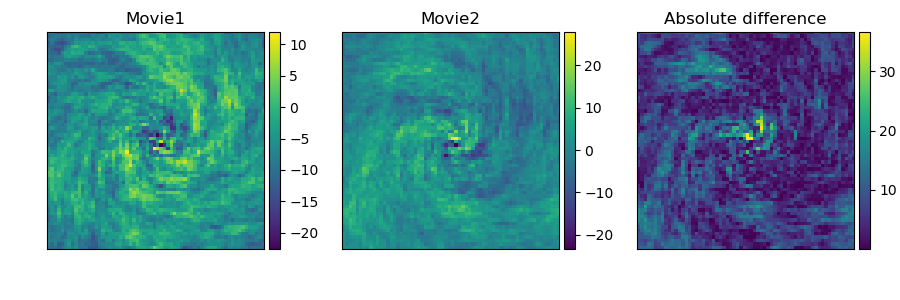

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [5]:
%matplotlib notebook
pynoisy.utils.compare_movie_frames(multi_sample[0], multi_sample[1])

<IPython.core.display.Javascript object>


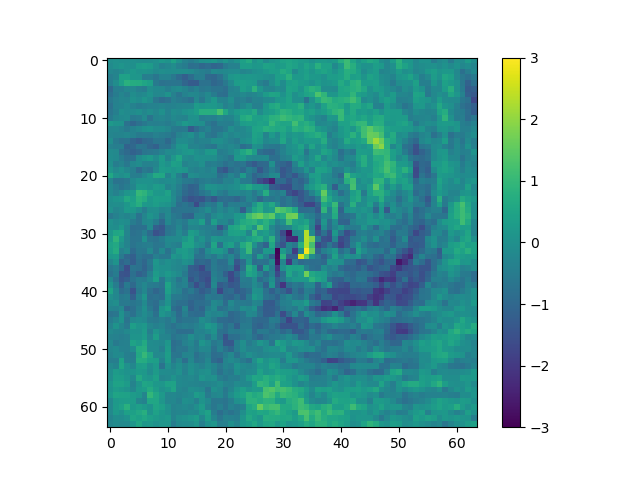

In [6]:
multi_sample.mean(dim='sample').noisy_methods.get_animation(vmin=-3, vmax=3)

<IPython.core.display.Javascript object>


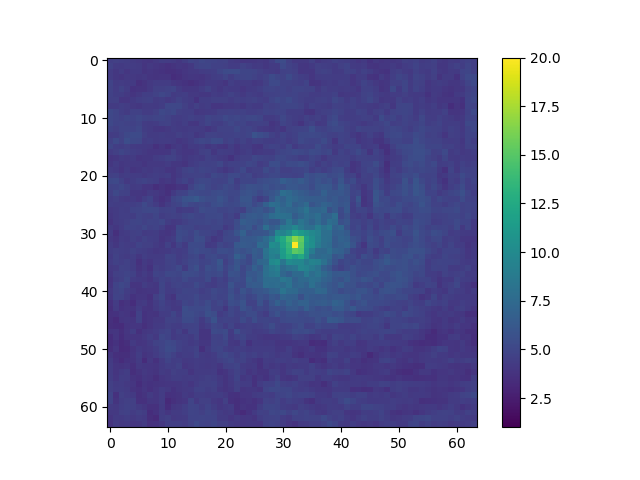

In [7]:
multi_sample.std(dim='sample').noisy_methods.get_animation(vmin=1, vmax=20)

In [13]:
multi_sample = solver.run_asymmetric(64, 64, num_samples=1000, n_jobs=12)

100%|██████████| 1000/1000 [52:51<00:00,  3.17s/it] 


<IPython.core.display.Javascript object>


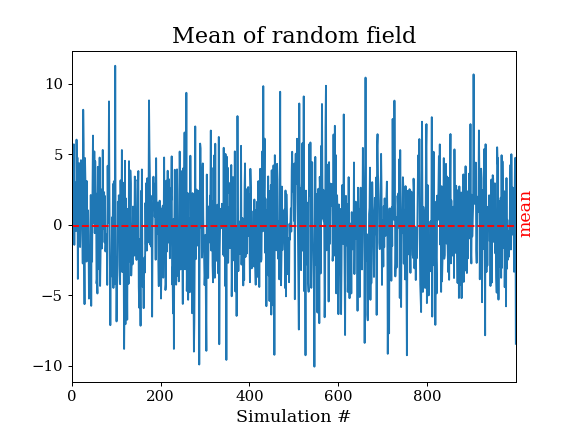

In [23]:
mean = multi_sample.mean(dim=['t', 'x', 'y'])

plt.figure()
plt.plot(mean)
plt.title('Mean of random field', fontsize=18)
plt.xlabel('Simulation #', fontsize=14)
plt.axhline(mean.mean(), linestyle='--', color='r')
plt.text(1002 ,mean.mean()-0.5,'mean',rotation=90, color='r', fontsize=14)
plt.xlim([0, multi_sample.sizes['sample']-1]);

## Loss Analysis

In [2]:
# Generate synthetic measurements
advection_true = pynoisy.advection.disk(64, 64)
diffusion_true = pynoisy.diffusion.ring(64, 64)
solver = pynoisy.forward.NoisySolver(64, 64, advection_true, diffusion_true)
measurements = solver.run_asymmetric(num_frames=50, verbose=False)

### Mean square error

In [6]:
n_jobs = 60
num_samples = 120

angle_range = np.linspace(0, np.pi, 40)
loss_std, loss_mean = [], []

for angle in tqdm(angle_range):
    solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=angle))
    solver.reseed()
    synthetic_measurements = solver.run_asymmetric(num_samples=num_samples, n_jobs=n_jobs, verbose=False)
    error = ((synthetic_measurements - measurements)**2).mean(dim=['t', 'x', 'y'])
    loss_mean.append(error.mean())
    loss_std.append(error.std())

loss = xr.Dataset(
    data_vars={'mean': ('opening_angle', np.array(loss_mean)), 
               'std': ('opening_angle', np.array(loss_std))},
    coords={'opening_angle': angle_range},
    attrs={'num_samples': num_samples}
)

Setting solver seed to: 15184


<IPython.core.display.Javascript object>


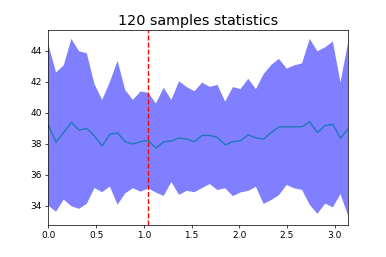

In [7]:
%matplotlib notebook
loss.noisy_methods.plot_statistics()
plt.axvline(diffusion_true.opening_angle, color='r', linestyle='--')


### Noise PCA

In [4]:
n_jobs = 60
num_samples = 120
n_components = 8
angle_range = np.linspace(0, 1.5*np.pi, 50)
loss = []

for angle in tqdm(angle_range):
    solver.set_diffusion(pynoisy.diffusion.ring(64, 64, opening_angle=angle))
    solver.reseed()
    synthetic_measurements = solver.run_asymmetric(num_samples=num_samples, num_frames=50, n_jobs=n_jobs, verbose=False)
    X = np.array(synthetic_measurements).reshape(synthetic_measurements.sizes['sample'], -1)
    pca = PCA(n_components)
    pca.fit(X)
    components = pca.components_
    error = np.linalg.lstsq(components.T, np.array(measurements).ravel(), rcond=None)[1]
    loss.append(error)
loss = np.array(loss)

Setting solver seed to: 31042


<IPython.core.display.Javascript object>


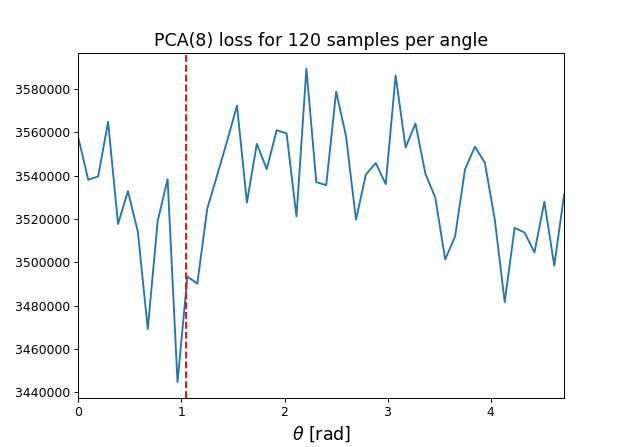

In [5]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('PCA({}) loss for {} samples per angle'.format(n_components, num_samples), fontsize=14)
ax.plot(angle_range, np.array(loss))
ax.axvline(diffusion_true.opening_angle, color='r', linestyle='--');
ax.set_xlabel(r'$\theta$ [rad]', fontsize=14)
ax.set_xlim([0.0, 1.5*np.pi]);